# Task 2.2: Data Exploration by PCA and Clustering
## for Weekly Aggregated Data
Inspiration:
1. https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
2. Notebooks from COMP-551

Possibilities?
- https://towardsdatascience.com/using-k-means-clustering-for-image-segregation-fd80bea8412d

Notes:
- for NaN data, they are converted to = 0.0

## PCA & KMeans: Weekly Search Trends

We want to classify the Weekly Search Trends Dataset for 11 US States

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns

df = pd.read_csv('../Data/demedian_USA_coviddata_clean_25.csv')
symptoms = [key for key in df.keys() if 'symptom:' in key ]
data=np. array([])
for symptom in symptoms: 
    symptom_dat = np.reshape(df[symptom].values, (1,11*38))
    data = np.append(data,symptom_dat)
data= np.reshape(data,(len(symptoms),11*38))
data = np.nan_to_num(data)
data = data.T
data.shape

(418, 91)

### Step 1: Find Optimal Number of Components for PCA
The least number of components required to explain 95% of the data variance

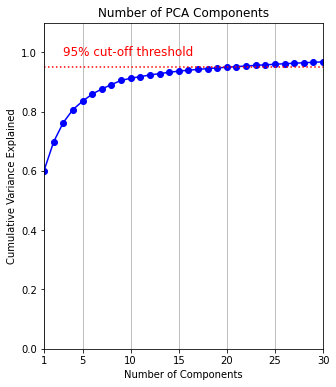

In [2]:
pca = PCA().fit(data)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,6)
fig, ax = plt.subplots()
xi = np.arange(1, 92, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='b')

plt.xlabel('Number of Components')
plt.xticks([1,5,10,15,20,25,30]) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative Variance Explained')
plt.title('Number of PCA Components')

plt.axhline(y=0.95, color='r', linestyle=':')
plt.text(3, 0.99, '95% cut-off threshold', color = 'red', fontsize=12)
plt.xlim(1,30)
ax.grid(axis='x')
plt.show()

We found that  18 components worked the best for the symptoms search trend data

#### Step 2: Visualise PCA Reduced Data in 2-D
we visualise the PCA-reduced data, and colour the points according to the region represented

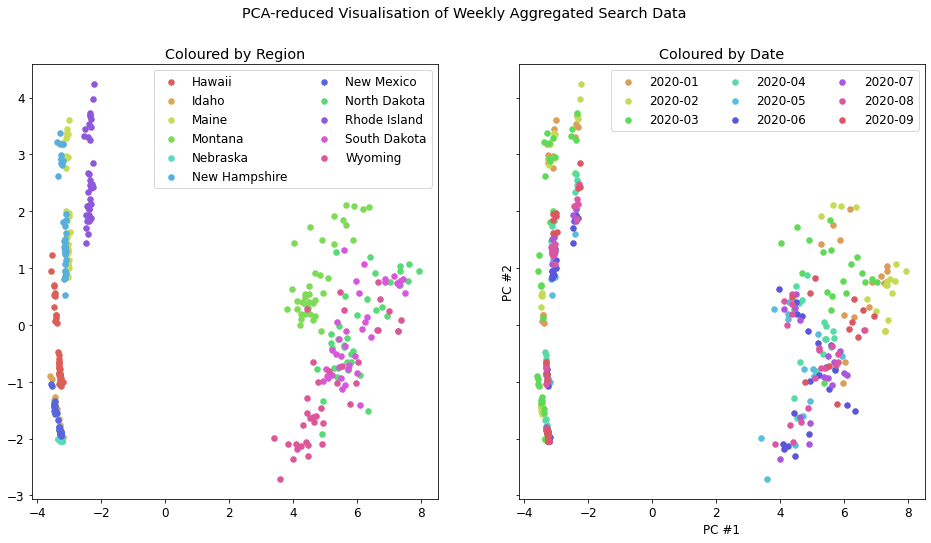

In [3]:
# A. Apply PCA: Reduce Dimensionality to X number of components
reduced_data = PCA(n_components=18).fit_transform(data)

plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(1,2, sharex=True, sharey = True)


# Plots with features colored by region
region = df.loc[:,'sub_region_1'].values

groups = df['sub_region_1'].unique()
colors =  sns.color_palette("hls", len(groups)) #sns.cubehelix_palette(11).as_hex()

color_dict=dict(zip(groups,colors))
plt.rcParams["figure.figsize"] = (8,8)
for g in np.unique(region):
    ix = np.where(region == g)
    ax[0].scatter(reduced_data[ix,0], reduced_data[ix,1], color = color_dict[g], label = g, s = 30)
ax[0].legend(bbox_to_anchor=(1, 1),ncol=2)
ax[0].set_title('Coloured by Region')

# Plots with features colored by date
region = df.loc[:,'date'].values
region = np.array([reg[:7] for reg in region])
groups = df['date'].unique()
groups = np.array([grp[:7] for grp in groups])
colors =  sns.color_palette("hls", len(groups)) #sns.cubehelix_palette(11).as_hex()
color_dict=dict(zip(groups,colors))
plt.rcParams["figure.figsize"] = (8,8)
for g in np.unique(region):
    ix = np.where(region == g)
    ax[1].scatter(reduced_data[ix,0], reduced_data[ix,1], color = color_dict[g], label = g, s = 30)
ax[1].legend(bbox_to_anchor=(1, 1),ncol=3)
ax[1].set_title('Coloured by Date')

plt.suptitle('PCA-reduced Visualisation of Weekly Aggregated Search Data')
plt.xticks()
plt.yticks()
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.show()

The PCA-reduced spread of data indicates that each region's search trend data clusters along a specific set of trends. This suggest possible region-based clustering, i.e. that there a several regions with similar weekly search trend characteristics. We explore this further using K-means clustering.

### Step 3: K-Means Clustering of Weekly Search Trend Data

we try K-means clustering for both the raw and PCA-reduced dataset for a number of K's to see the optimum number of clusters.

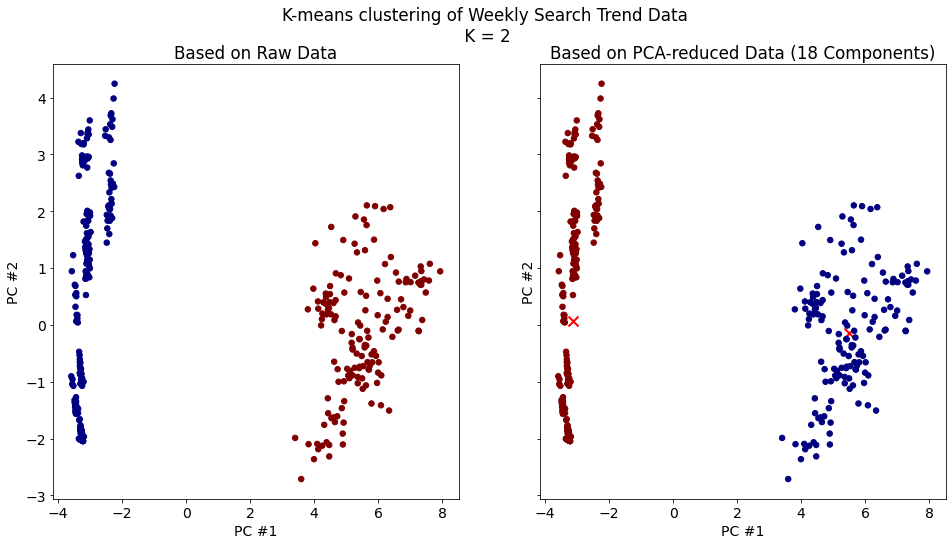

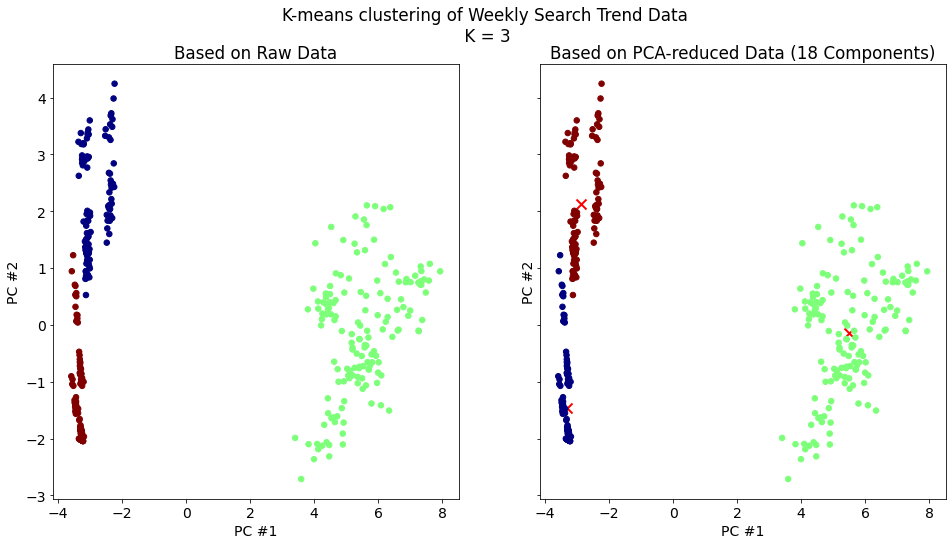

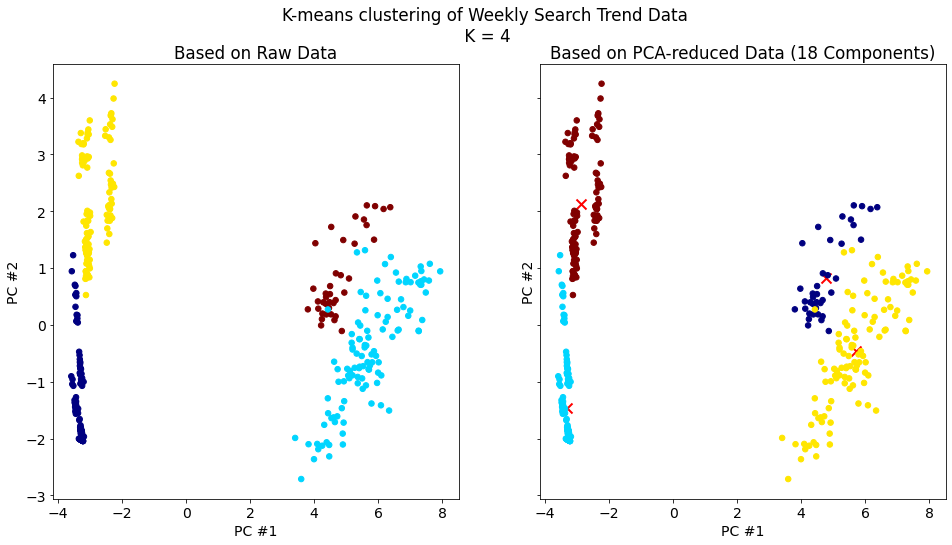

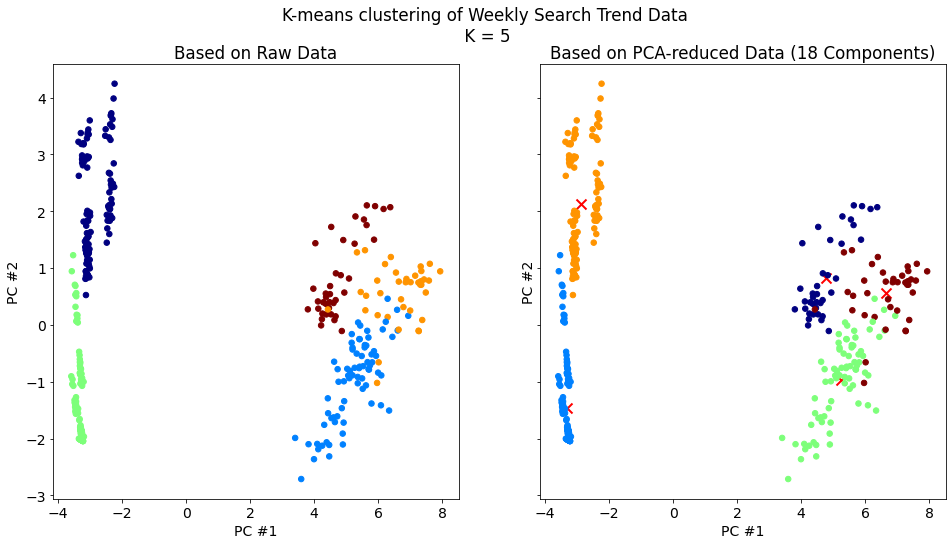

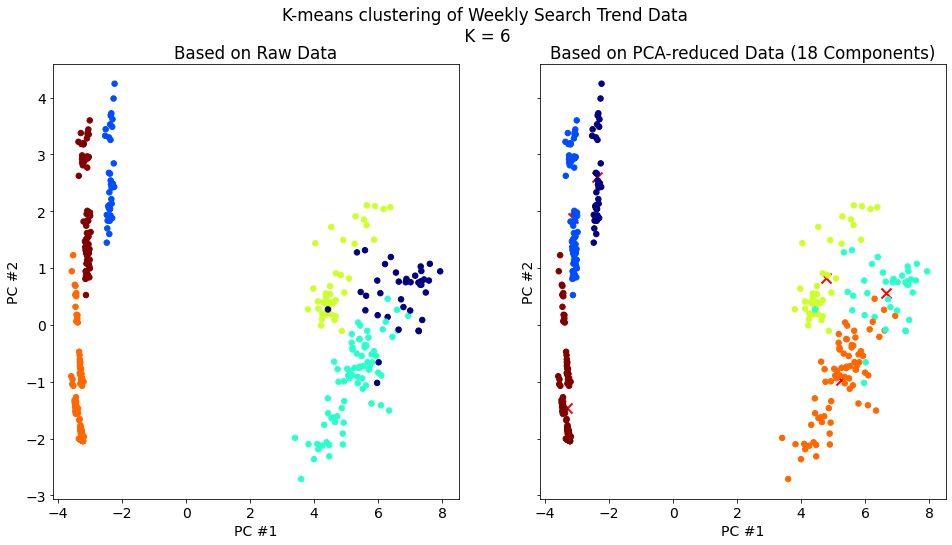

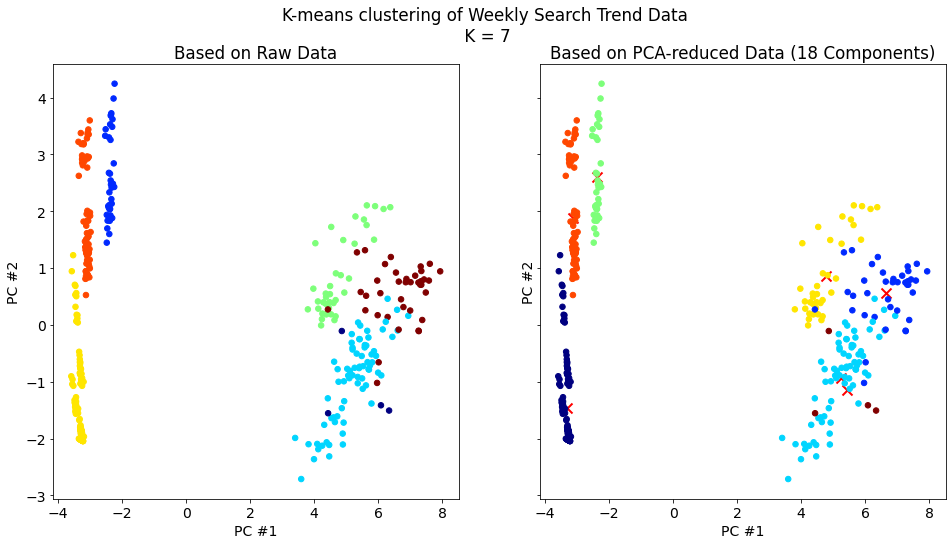

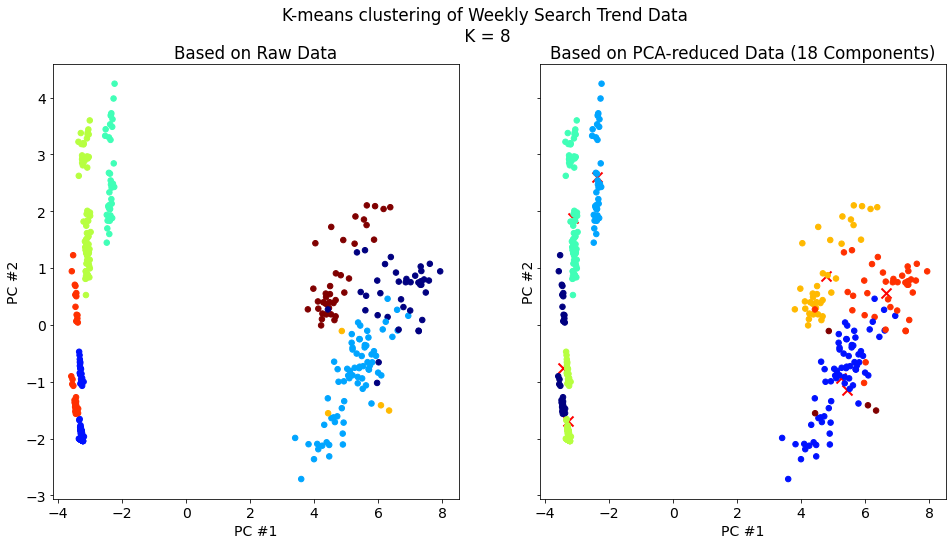

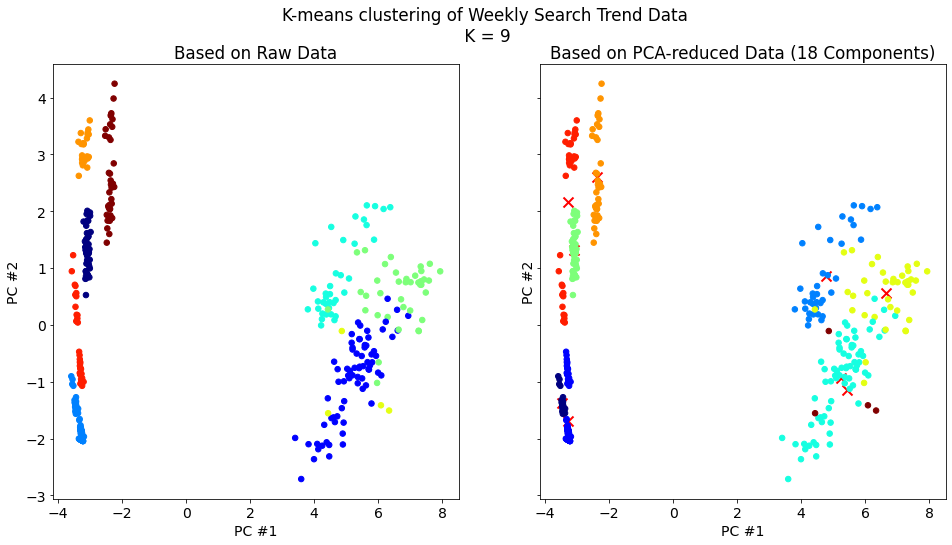

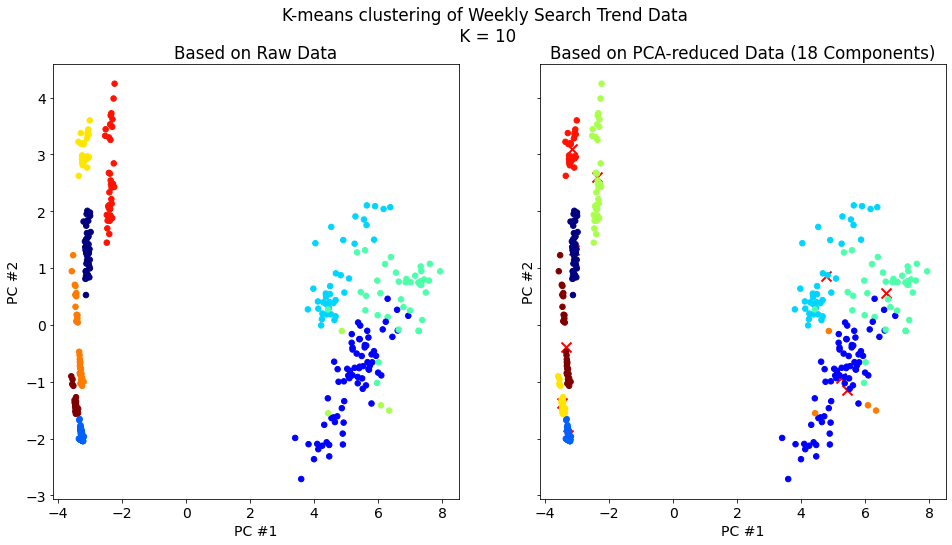

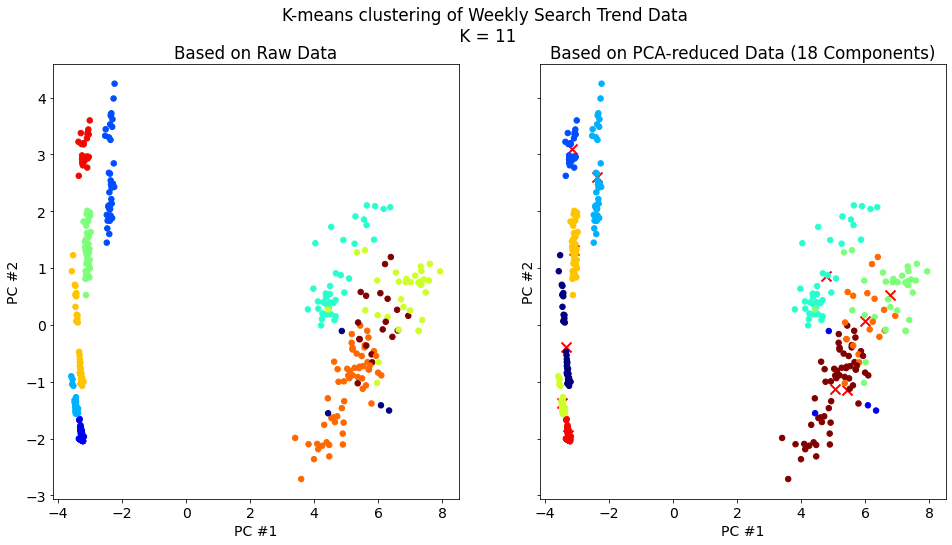

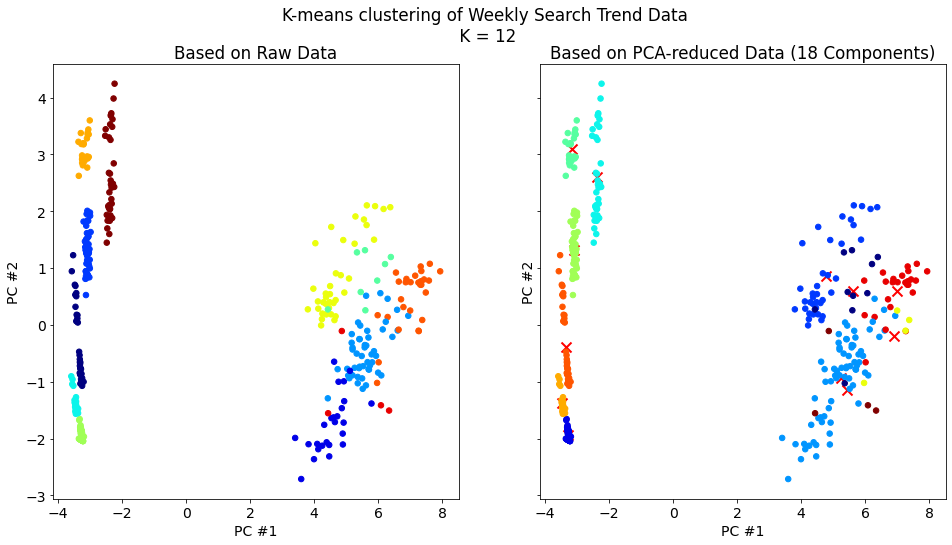

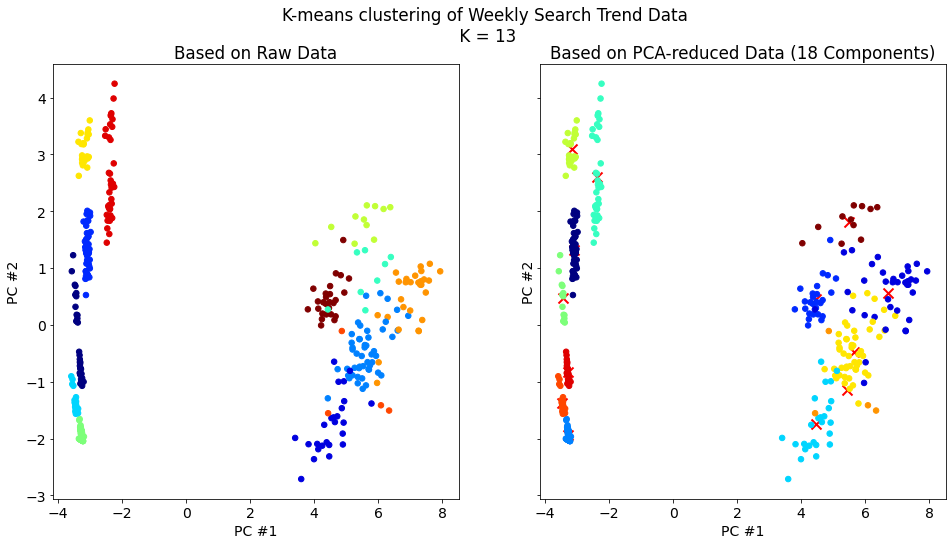

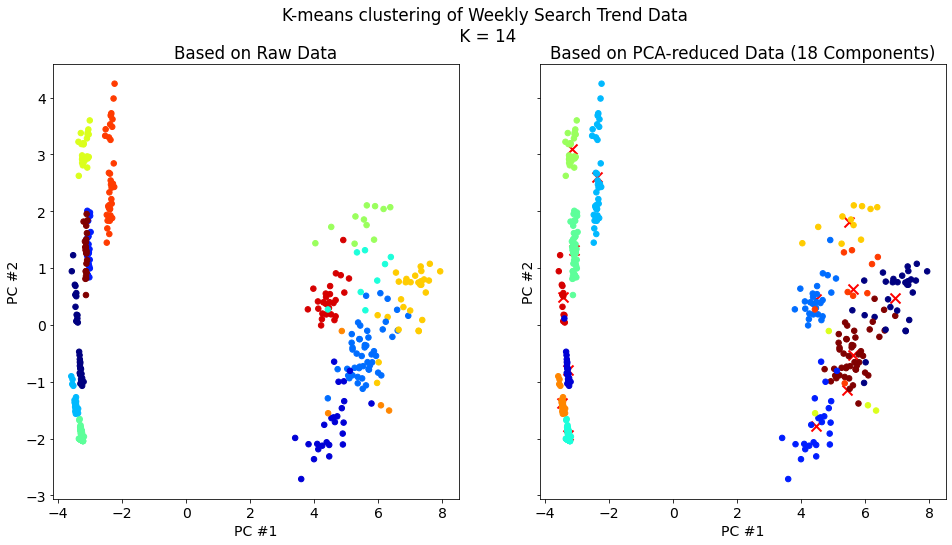

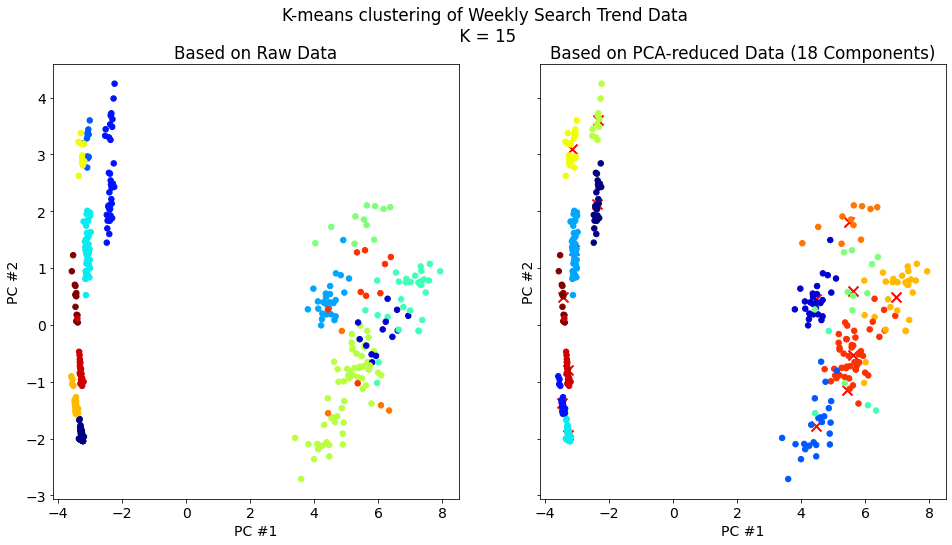

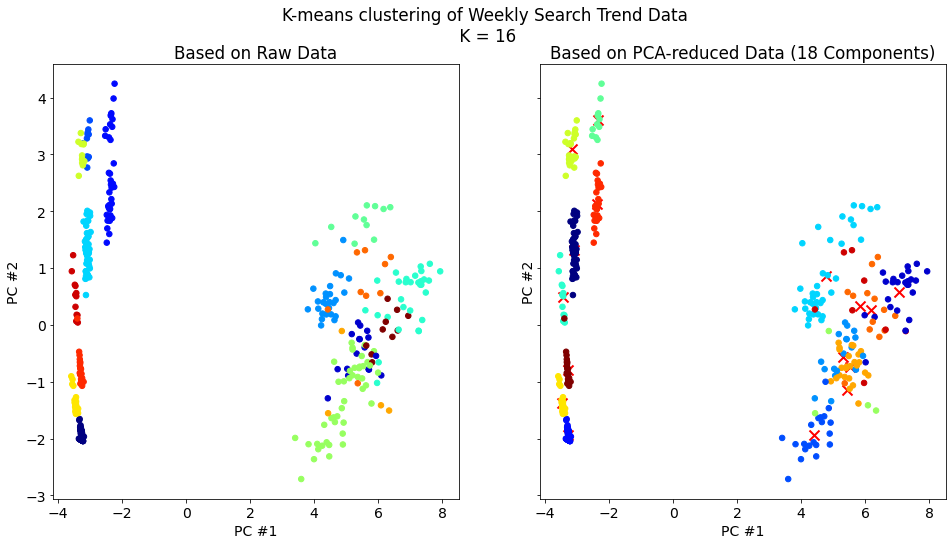

In [4]:
n_pca = 18 # number of componenets

for K in np.arange(2,17): # for a series of K (clusters)
    # A. Apply PCA: Reduce Dimensionality to X number of components
    reduced_data = PCA(n_components=n_pca).fit_transform(data)

    # B. Apply KMeans Clustering using both raw and reduced dataset
    kmeans = KMeans(n_clusters=K, random_state=0)
    kmeans.fit(data)
    y_pred = kmeans.predict(data)

    kmeans_pca = KMeans(init='k-means++', n_clusters=K)
    kmeans_pca.fit(reduced_data)
    y_pred_pca = kmeans_pca.predict(reduced_data)

    # C. Visualise Results
    plt.rcParams["figure.figsize"] = (16,8)
    plt.rcParams.update({'font.size': 14})

    fig, ax = plt.subplots(1,2,sharey=True)
    ax[0].set_title('Based on Raw Data')
    preds = ax[0].scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_pred,s=30,cmap=plt.cm.get_cmap('jet'),zorder=1)
    ax[0].set_xlabel("PC #1")
    ax[0].set_ylabel("PC #2")

    ax[1].set_title('Based on PCA-reduced Data (18 Components)')
    preds = ax[1].scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_pred_pca,s=30,cmap=plt.cm.get_cmap('jet'),zorder=1)
    ## Plot the cluster centroids as a red X
    centroids = kmeans_pca.cluster_centers_
    ax[1].scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=100, linewidths=2,
                color='r', zorder=0)
    ax[1].set_xlabel("PC #1")
    ax[1].set_ylabel("PC #2")

    plt.suptitle('K-means clustering of Weekly Search Trend Data\n K = '+str(K)+'\n')
    #plt.savefig('../Plots/'+str(K)+'_regionclusters.png')
    plt.show()
    